In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

In [2]:
df = pd.read_csv(r"quora_questions.csv")
print(df.tail(5))
print(df.head(5))

df = df.loc[:10000,:]

                                                                                              Question
404284  How many keywords are there in the Racket programming language of the latest version?         
404285  Do you believe there is life after death?                                                     
404286  What is one coin?                                                                             
404287  What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?
404288  What is like to have sex with cousin?                                                         
                                                                       Question
0  What is the step by step guide to invest in share market in india?          
1  What is the story of Kohinoor (Koh-i-Noor) Diamond?                         
2  How can I increase the speed of my internet connection while using a VPN?   
3  Why am I mentally very lonely? How can I solve it?         

In [3]:
data_text = df[['Question']]
data_text['index'] = df.index
documents = data_text

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

import nltk
#nltk.download('wordnet')

In [5]:
def lemmatize(text):
    return (WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

In [6]:
processed_docs = documents['Question'].map(preprocess)
processed_docs[:5]

0    [step, step, guide, invest, share, market, india]             
1    [story, kohinoor, noor, diamond]                              
2    [increase, speed, internet, connection]                       
3    [mentally, lonely, solve]                                     
4    [dissolve, water, quikly, sugar, salt, methane, carbon, oxide]
Name: Question, dtype: object

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
words = cv.fit_transform([str(docs) for docs in processed_docs])
sum_words = words.sum(axis=0)
words_freq = [(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x:x[1], reverse=True)

In [8]:
frequency = pd.DataFrame(words_freq, columns=['word','freq'])

import matplotlib.pyplot as plt
color = plt.cm.twilight(np.linspace(0,1,50))
frequency.head(50).plot(x='word',y='freq',kind='bar',figsize=(20,10),color=color)
plt.title("Most Frequent Words")
plt.show()

<Figure size 2000x1000 with 1 Axes>

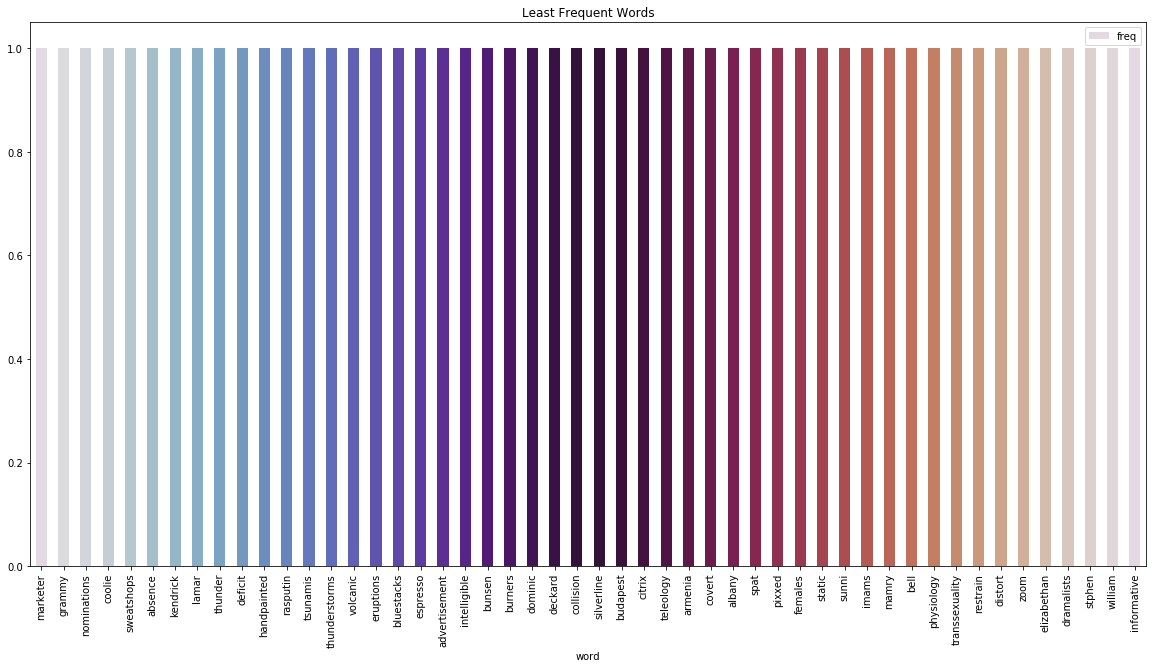

In [9]:
frequency.tail(50).plot(x='word',y='freq',kind='bar',figsize=(20,10),color=color)
plt.title("Least Frequent Words")
plt.show()

In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=20000)
dictionary.compactify()

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [11]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [12]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=5)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.048*"best" + 0.020*"change" + 0.020*"account" + 0.016*"need" + 0.016*"money" + 0.015*"question" + 0.013*"place" + 0.013*"note" + 0.012*"india" + 0.012*"delete"
Topic: 1 Word: 0.035*"like" + 0.017*"thing" + 0.017*"prepare" + 0.017*"better" + 0.016*"movies" + 0.014*"best" + 0.012*"effect" + 0.011*"exam" + 0.011*"women" + 0.011*"months"
Topic: 2 Word: 0.027*"think" + 0.017*"game" + 0.017*"live" + 0.017*"number" + 0.015*"like" + 0.015*"real" + 0.014*"data" + 0.014*"good" + 0.014*"code" + 0.013*"india"
Topic: 3 Word: 0.046*"difference" + 0.032*"work" + 0.018*"start" + 0.017*"best" + 0.017*"time" + 0.016*"phone" + 0.015*"year" + 0.013*"learn" + 0.012*"play" + 0.011*"examples"
Topic: 4 Word: 0.045*"people" + 0.042*"quora" + 0.027*"mean" + 0.019*"feel" + 0.017*"question" + 0.015*"travel" + 0.015*"weight" + 0.013*"like" + 0.013*"lose" + 0.012*"come"
Topic: 5 Word: 0.026*"india" + 0.018*"best" + 0.018*"life" + 0.018*"cause" + 0.017*"think" + 0.014*"things" + 0.013*"good" + 0.012

In [13]:
# Compute Coherence Score using c_v

from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5934369691769354


In [14]:
from gensim.models import LdaModel, LdaMulticore

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=2, iterations = 30, workers=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus_tfidf, texts=processed_docs, 
                                                        start=4, limit=45, step=3)

Wall time: 5min 53s


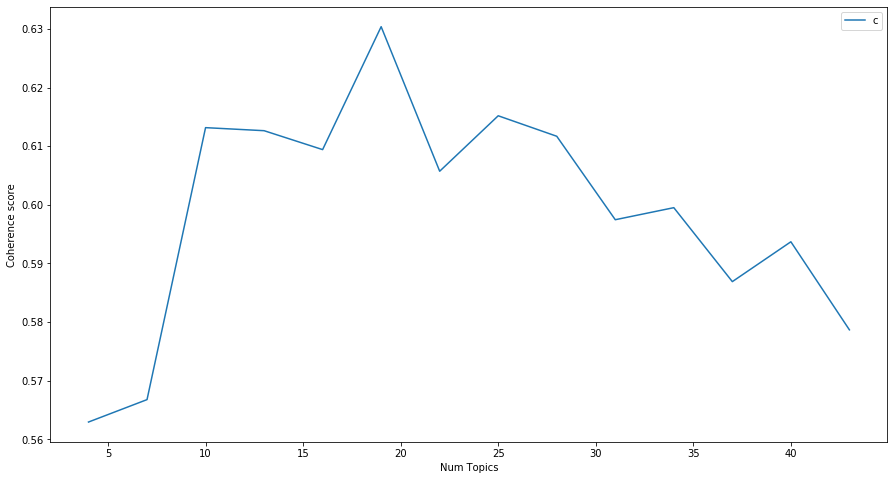

In [16]:
plt.figure(figsize=(15,8))

x = range(4, 45, 3)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=18, id2word=dictionary,iterations = 30, passes=2, workers=5)

print(lda_model_tfidf.print_topics())

[(0, '0.038*"life" + 0.031*"quora" + 0.022*"come" + 0.016*"answer" + 0.015*"best" + 0.015*"india" + 0.014*"go" + 0.013*"name" + 0.013*"difference" + 0.013*"lose"'), (1, '0.035*"learn" + 0.034*"better" + 0.033*"work" + 0.027*"book" + 0.024*"trump" + 0.022*"best" + 0.020*"language" + 0.016*"donald" + 0.014*"president" + 0.014*"function"'), (2, '0.030*"start" + 0.027*"water" + 0.021*"favorite" + 0.018*"test" + 0.018*"type" + 0.017*"best" + 0.017*"important" + 0.016*"meet" + 0.016*"music" + 0.015*"major"'), (3, '0.037*"money" + 0.024*"human" + 0.024*"differences" + 0.022*"university" + 0.022*"online" + 0.020*"like" + 0.018*"weight" + 0.017*"speak" + 0.017*"girl" + 0.015*"english"'), (4, '0.093*"difference" + 0.051*"mean" + 0.024*"quora" + 0.019*"good" + 0.017*"movies" + 0.015*"question" + 0.013*"windows" + 0.013*"visit" + 0.013*"mobile" + 0.012*"life"'), (5, '0.135*"best" + 0.039*"people" + 0.020*"place" + 0.019*"prepare" + 0.017*"free" + 0.015*"home" + 0.014*"look" + 0.013*"movies" + 0.01

In [22]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary=lda_model_tfidf.id2word)
pyLDAvis.save_html(vis,'quora_lda.html')

C:\Users\Abhishek\Anaconda3\envs\tf_gpu\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.038*"life" + 0.031*"quora" + 0.022*"come" + 0.016*"answer" + 0.015*"best" + 0.015*"india" + 0.014*"go" + 0.013*"name" + 0.013*"difference" + 0.013*"lose"
Topic: 1 Word: 0.035*"learn" + 0.034*"better" + 0.033*"work" + 0.027*"book" + 0.024*"trump" + 0.022*"best" + 0.020*"language" + 0.016*"donald" + 0.014*"president" + 0.014*"function"
Topic: 2 Word: 0.030*"start" + 0.027*"water" + 0.021*"favorite" + 0.018*"test" + 0.018*"type" + 0.017*"best" + 0.017*"important" + 0.016*"meet" + 0.016*"music" + 0.015*"major"
Topic: 3 Word: 0.037*"money" + 0.024*"human" + 0.024*"differences" + 0.022*"university" + 0.022*"online" + 0.020*"like" + 0.018*"weight" + 0.017*"speak" + 0.017*"girl" + 0.015*"english"
Topic: 4 Word: 0.093*"difference" + 0.051*"mean" + 0.024*"quora" + 0.019*"good" + 0.017*"movies" + 0.015*"question" + 0.013*"windows" + 0.013*"visit" + 0.013*"mobile" + 0.012*"life"
Topic: 5 Word: 0.135*"best" + 0.039*"people" + 0.020*"place" + 0.019*"prepare" + 0.017*"free" + 0.015*"